In [15]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [28]:
yf.pdr_override()
df = pdr.get_data_yahoo("EMD=F", start="2022-01-01", end="2023-03-20")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


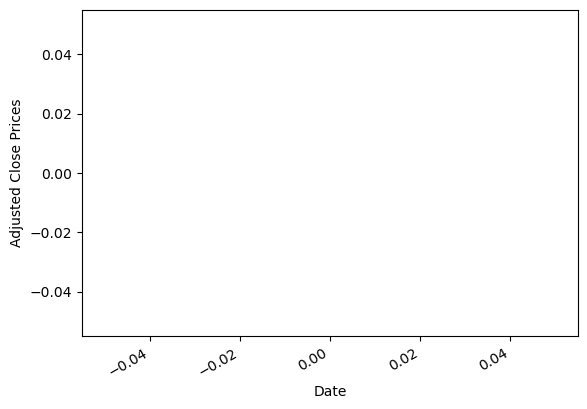

In [29]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [67]:
df.dropna(inplace=True)

In [68]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(304,)

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [70]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [71]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 30, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 11, 'bootstrap': False}


In [76]:
model = RandomForestRegressor(n_estimators=20, random_state=30, min_samples_split=2, min_samples_leaf=1, max_depth=11, bootstrap=False)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[4557.     4346.5    3888.8    4066.9375 4160.8    4005.85   4188.75
 4064.925  3812.35   4187.4375 4158.25   3895.5    4359.025  4089.1125
 3975.     4346.5    4028.375  4631.75   4489.125  4471.     3882.5
 4023.6    4524.5    4045.425  4027.25   4028.     4498.     4228.5375
 4008.05   4121.95   4033.25   4684.75   4214.     4498.     4306.2625
 3745.3    4631.75   3949.525  4033.25   4038.1875 4071.85   3857.25
 3933.     4181.5    4657.25   3979.6125 4028.45   3743.     4324.1875
 3905.925  3905.725  4584.85   4144.875  4698.75   4299.25   4024.5
 4166.0375 3827.5875 3744.25   4590.6    3830.0875 3979.6125 4595.
 4524.5    4209.     4375.5    4166.65   3959.7375 4008.05   3960.6125
 4056.2125 4424.5    4058.75   4548.     4278.5    3792.75   4005.9
 3710.5125 4524.5    4196.4625]
(80,)


In [77]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 2.9948
Mean Squared Error: 18.0877
Root Mean Squared Error: 4.253
(R^2) Score: 0.9997
Train Score : 100.00% and Test Score : 99.97% using Random Tree Regressor.
Accuracy: 99.93 %.


In [78]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
   Unnamed: 0  Predictions
8  2023-03-25      3812.35
8    3812.35
Name: Predictions, dtype: float64
Sell price and date
17    4631.75
Name: Predictions, dtype: float64


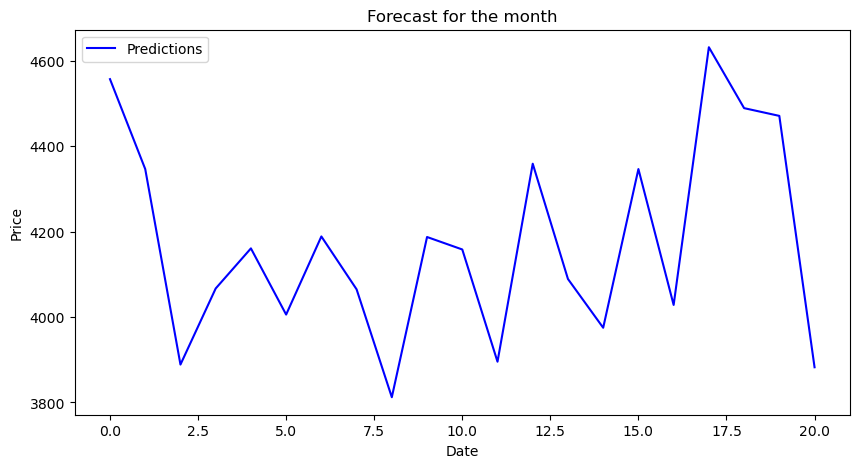

In [79]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()